In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py
s = Storage()
assert s.pickle_exists('HEADER_PATTERN_DICT')
HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')


I have a dictionary of variable-length sequences:

In [3]:

[(file_name[-10:], len(tag_is_header_list)) for file_name,
 tag_is_header_list in HEADER_PATTERN_DICT.items()]

[('37bd1.html', 25), ('0bcce.html', 40), ('90364.html', 28), ('8f9c7.html', 24), ('d12d4.html', 73), ('46837.html', 37), ('adb92.html', 53), ('0a1e7.html', 69), ('da077.html', 43), ('9366a.html', 21), ('6ae4d.html', 37), ('f62ee.html', 19), ('73aee.html', 33), ('e090a.html', 35), ('8b093.html', 44)]


These contain a label for each item as to whether or not they are a subject heading:

In [4]:

HEADER_PATTERN_DICT[sorted([(file_name, len(tag_is_header_list)) for file_name,
                            tag_is_header_list in HEADER_PATTERN_DICT.items()],
                           key=lambda x: x[1])[0][0]]

[(None, True), ('<div', False), ('<div', False), (None, True), (None, False), ('<li', False), ('<li', False), ('<li', False), (None, False), (None, False), ('<li', False), ('<li', False), ('<li', False), (None, True), (None, True), ('<li', False), ('<li', False), ('<li', False), ('<div', False)]


Is there some variable-length sequence vectorization I can do such that I can train a model to predict the label? What is the best way to train that model? Are there machine learning algorithms for this that allow training without the use of a GPU?


----

In [41]:

true_idx_dict = {}
double_header_dict = {}
for file_name, tag_is_header_list in HEADER_PATTERN_DICT.items():
    true_idx_list = []
    double_header_idx_list = []
    for i, tag_tuple in enumerate(tag_is_header_list):
        if tag_tuple[1]:
            true_idx_list.append(i)
    for idx in true_idx_list:
        next_idx = idx + 1
        if next_idx < len(tag_is_header_list):
            item_tag = tag_is_header_list[next_idx][0]
            item_idx = next_idx + 1
            while (item_idx < len(tag_is_header_list)) and (tag_is_header_list[item_idx][0] == item_tag):
                item_tag = tag_is_header_list[item_idx][0]
                item_idx = item_idx + 1
            if (item_idx < len(tag_is_header_list)) and tag_is_header_list[item_idx][1]:
                idx_tuple = (idx, item_idx)
                double_header_idx_list.append(idx_tuple)
    if len(double_header_idx_list):
        double_header_dict[file_name] = double_header_idx_list
    if len(true_idx_list):
        true_idx_dict[file_name] = true_idx_list

In [38]:

%run .../py/html_analysis.py

In [40]:

from bs4 import BeautifulSoup
from bs4.element import NavigableString

file_name = sorted([(f, l) for f, l in double_header_dict.items()], key=lambda x: len(x[1]))[-1][0]
file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
with open(file_path, 'r', encoding='utf-8') as f:
    html_str = f.read()
    job_soup = BeautifulSoup(html_str, 'lxml')
    body_soup = job_soup.find_all(name='body')[0]
    child_strs_list = get_navigable_children(body_soup, [])

In [45]:

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

# Re-transform the bag-of-words and tf-idf from the new manual scores
NAVIGABLE_PARENT_IS_HEADER_DICT = s.load_object('NAVIGABLE_PARENT_IS_HEADER_DICT')
rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in NAVIGABLE_PARENT_IS_HEADER_DICT.items()]
child_str_df = pd.DataFrame(rows_list)

assert child_str_df.shape[0]
sents_list = child_str_df.navigable_parent.tolist()
CLF_NAME = 'LdaModel'
#CLF_NAME = 'LogisticRegression'

In [46]:

if(CLF_NAME == 'LdaModel'):
    
    # Build model with tokenized words
    tokenized_sents_list = [regex_tokenizer(sent_str) for sent_str in sents_list]
    
    # Create a corpus from a list of texts
    HEADERS_DICTIONARY = Dictionary(tokenized_sents_list)
    headers_corpus = [HEADERS_DICTIONARY.doc2bow(tag_str) for tag_str in tokenized_sents_list]
    
    # Train the model on the corpus
    LDA = LdaModel(corpus=headers_corpus, num_topics=2)
    
else:
    
    # Bag-of-words
    cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                            'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                            'tokenizer': regex_tokenizer})
    
    # The shape of the count vector here should be n sentences * m unique words
    bow_matrix = cv.fit_transform(sents_list)
    
    # Store the resulting vocabulary; the numbers are not counts, they are the position in the sparse vector
    s.store_objects(cs_cv_vocab=cv.vocabulary_)
    
    # Tf-idf must get from Bag-of-words first
    tt = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(CS_TT=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = child_str_df.is_header.to_numpy()
    FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')
    child_str_clf = FIT_ESTIMATORS_DICT[CLF_NAME]
    child_str_clf.fit(X, y)
    FIT_ESTIMATORS_DICT[CLF_NAME] = child_str_clf
    s.store_objects(child_str_clf=child_str_clf, FIT_ESTIMATORS_DICT=FIT_ESTIMATORS_DICT)
    
    # Re-calibrate the inference engine
    cs_cv_vocab = s.load_object('cs_cv_vocab')
    CS_CV = CountVectorizer(vocabulary=cs_cv_vocab)
    CS_CV._validate_vocabulary()
    CS_TT = s.load_object('CS_TT')

In [67]:

%run ../py/html_analysis.py

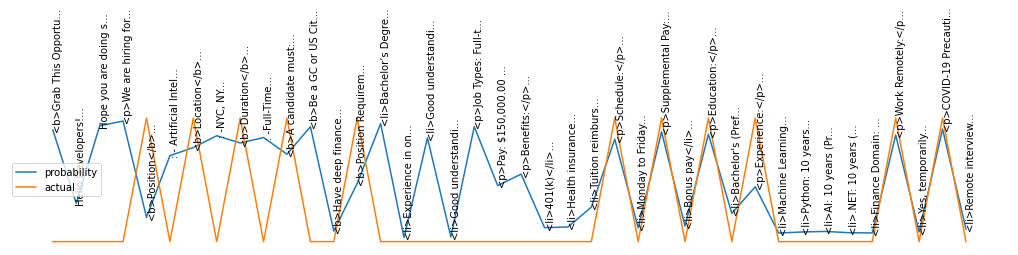

In [68]:

import matplotlib.pyplot as plt

rows_list = []
for child_str in child_strs_list:
    y_predict_proba = predict_percent_fit([child_str])[0]
    if(CLF_NAME == 'LdaModel'):
        X = 1.0 - y_predict_proba
    else:
        X = y_predict_proba[0][1]
    row_dict = {'probability': X}
    if child_str in NAVIGABLE_PARENT_IS_HEADER_DICT:
        row_dict['actual'] = NAVIGABLE_PARENT_IS_HEADER_DICT[child_str] * 1.0
    else:
        row_dict['actual'] = np.nan
    rows_list.append(row_dict)
ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
df = pd.DataFrame(rows_list)
AxesSubplot_obj = df.plot.line(ax=ax)
ax.axis('off')
for i, child_str in enumerate(child_strs_list):
    ax.annotate(f'{child_str[:20]}...', (i, rows_list[i]['probability']), ha='left', rotation=90)


----

In [2]:

from IPython.display import clear_output
from bs4 import BeautifulSoup
from bs4.element import NavigableString
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from urllib.parse import urlparse, parse_qs
import numpy as np
import os
import random
import re
import requests
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

%run ../load_magic/storage.py
s = Storage()

LT_REGEX = re.compile(r'\s+<')
GT_REGEX = re.compile(r'>\s+')
SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')

In [3]:

%run .../py/html_analysis.py

In [5]:

def update_child_strs_list_dictionary(child_strs_list_dict=None, navigable_parent_is_header_dict=None):
    if navigable_parent_is_header_dict is None:
        navigable_parent_is_header_dict = s.load_object('navigable_parent_is_header_dict')
    if child_strs_list_dict is None:
        files_list = os.listdir(SAVES_HTML_FOLDER)
        child_strs_list_dict = {}
        for file_name in files_list:
            file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                html_str = f.read()
                job_soup = BeautifulSoup(html_str, 'lxml')
                body_soup = job_soup.find_all(name='body')[0]
                child_strs_list = get_navigable_children(body_soup, [])
            if not len(child_strs_list):
                os.remove(file_path)
            child_strs_list = [child_str for child_str in child_strs_list if child_str not in navigable_parent_is_header_dict]
            child_strs_list_dict[file_name] = child_strs_list
        
        return child_strs_list_dict
    
    for file_name, child_strs_list in child_strs_list_dict.items():
        child_strs_list = [child_str for child_str in child_strs_list if child_str not in navigable_parent_is_header_dict]
        if not len(child_strs_list):
            child_strs_list = child_strs_list_dict.pop(file_name)
            break
        else:
            child_strs_list_dict[file_name] = child_strs_list
    
    return child_strs_list_dict

In [7]:

%run ../py/html_analysis.py

In [9]:

def print_dictionary_code():
    NAVIGABLE_PARENT_IS_HEADER_DICT = s.load_object('NAVIGABLE_PARENT_IS_HEADER_DICT')
    child_strs_list_dict = update_child_strs_list_dictionary(CHILD_STRS_LIST_DICT, NAVIGABLE_PARENT_IS_HEADER_DICT)
    s.store_objects(CHILD_STRS_LIST_DICT=child_strs_list_dict)
    for file_name, child_strs_list in child_strs_list_dict.items():
        for tag_str in child_strs_list:
            print()
            print()
            if "'" in tag_str:
                print(f'''NAVIGABLE_PARENT_IS_HEADER_DICT["{tag_str}"] = False''')
            else:
                print(f'''NAVIGABLE_PARENT_IS_HEADER_DICT['{tag_str}'] = False''')
            print(f'''print(len(NAVIGABLE_PARENT_IS_HEADER_DICT.keys()))\ns.store_objects(NAVIGABLE_PARENT_IS_HEADER_DICT=NAVIGABLE_PARENT_IS_HEADER_DICT)''')
            break
        break

In [10]:

def get_dictionary_code():
    output_str = ''
    NAVIGABLE_PARENT_IS_HEADER_DICT = s.load_object('NAVIGABLE_PARENT_IS_HEADER_DICT')
    child_strs_list_dict = update_child_strs_list_dictionary(CHILD_STRS_LIST_DICT, NAVIGABLE_PARENT_IS_HEADER_DICT)
    s.store_objects(CHILD_STRS_LIST_DICT=child_strs_list_dict)
    for file_name, child_strs_list in child_strs_list_dict.items():
        for tag_str in child_strs_list:
            output_str += '\n'
            if "'" in tag_str:
                #output_str += f'''assert "{tag_str}" not in NAVIGABLE_PARENT_IS_HEADER_DICT\n'''
                output_str += f'''NAVIGABLE_PARENT_IS_HEADER_DICT["{tag_str}"] = False\n'''
            else:
                #output_str += f'''assert '{tag_str}' not in NAVIGABLE_PARENT_IS_HEADER_DICT\n'''
                output_str += f'''NAVIGABLE_PARENT_IS_HEADER_DICT['{tag_str}'] = False\n'''
            output_str += f'''print(len(NAVIGABLE_PARENT_IS_HEADER_DICT.keys()))\ns.store_objects(NAVIGABLE_PARENT_IS_HEADER_DICT=NAVIGABLE_PARENT_IS_HEADER_DICT)'''
            break
        break
    
    return output_str
ZMQInteractiveShell_obj = get_ipython()

In [11]:

%run ../py/html_analysis.py
print('Retraining complete')

Retraining complete


In [12]:

files_list = os.listdir(SAVES_HTML_FOLDER)


----
# Download Job HTML

In [12]:

import re
%run ../load_magic/storage.py
s = Storage()

SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')
files_list = os.listdir(SAVES_HTML_FOLDER)

%run ../py/html_analysis.py

assert s.pickle_exists('CHILD_STRS_LIST_DICT')
CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')
assert s.pickle_exists('NAVIGABLE_PARENT_IS_HEADER_DICT')
NAVIGABLE_PARENT_IS_HEADER_DICT = s.load_object('NAVIGABLE_PARENT_IS_HEADER_DICT')
HEADER_PATTERN_DICT = {}
for file_name in files_list:
    if file_name in CHILD_STRS_LIST_DICT:
        child_strs_list = CHILD_STRS_LIST_DICT[file_name]
    else:
        file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_str = f.read()
            job_soup = BeautifulSoup(html_str, 'lxml')
            body_soup = job_soup.find_all(name='body')[0]
            child_strs_list = get_navigable_children(body_soup, [])
    navigable_parent = child_strs_list[0]
    if navigable_parent not in NAVIGABLE_PARENT_IS_HEADER_DICT:
        continue
    child_tags_list = []
    is_header_list = []
    for navigable_parent in child_strs_list:
        if navigable_parent not in NAVIGABLE_PARENT_IS_HEADER_DICT:
            break
        tokenized_sent = regex_tokenizer(navigable_parent)
        first_token = tokenized_sent[0]
        if first_token[0] == '<':
            child_tags_list.append(first_token)
        else:
            child_tags_list.append('')
        is_header = NAVIGABLE_PARENT_IS_HEADER_DICT[navigable_parent]
        is_header_list.append(is_header)
    if len(child_tags_list) == len(child_strs_list):
        if file_name not in CHILD_STRS_LIST_DICT:
            CHILD_STRS_LIST_DICT[file_name] = child_strs_list
            s.store_objects(CHILD_STRS_LIST_DICT=CHILD_STRS_LIST_DICT)
        if file_name not in HEADER_PATTERN_DICT:
            tag_is_header_list = [(tag, is_header) for tag, is_header in zip(child_tags_list, is_header_list)]
            HEADER_PATTERN_DICT[file_name] = tag_is_header_list
            s.store_objects(HEADER_PATTERN_DICT=HEADER_PATTERN_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle


In [9]:

%run ../load_magic/storage.py
s = Storage()
base_url = 'https://www.indeed.com'
site_url = base_url + '/jobs'
site_url = '?'.join([site_url, 'q=data+scientist'])
site_url = '&'.join([site_url, 'jt=fulltime'])
site_url = '&'.join([site_url, 'remotejob=032b3046-06a3-4876-8dfd-474eb5e7ed11'])
site_url = '&'.join([site_url, 'vjk=ca16b63c03e40c57'])
#site_url = '&'.join([site_url, 'pp=gQAPAAABdY7RMKwAAAABkQdgZAAkAQBEKPpaoZstIag3f-UtQXXG_HFSo1gfBp9OQ0B0TvZ4yMp4AAA'])
start_num = 0
try:
    job_urls_list = s.load_object('job_urls_list')
except:
    job_urls_list = []
    s.store_objects(job_urls_list=job_urls_list)
space_regex = re.compile(r'[\s<>:"/\\\|\?\*_]+')
print_regex = re.compile(r'[\x9c-\x9d\uf0b7\u200b\ufb02]+')
s.encoding_type = ['latin1', 'iso8859-1', 'utf-8'][2]

In [21]:

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(SAVES_HTML_FOLDER)]
row_count = len(job_urls_list)
for i, job_url in enumerate(job_urls_list):
    qs = urlparse(job_url).query
    query_dict = parse_qs(qs)
    fccid_str = query_dict['fccid'][0]
    file_name = f'{fccid_str}.html'
    if file_name not in fccid_htmls_list:
        job_page = requests.get(url=job_url)
        job_soup = BeautifulSoup(job_page.content, 'lxml')
        if not len(job_soup.text):
            break
        title_str = job_soup.find_all(name='title')[0].text.strip()
        clear_output(wait=True)
        print(f'{title_str}')
        print(f'{i}/{row_count}: {job_url}')
        if 'CAPTCHA' in title_str:
            break
        file_name = space_regex.sub('_', title_str)
        file_name = f'{file_name}_{fccid_str}.html'
        file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
        body_soup = job_soup.find_all(name='body')[0]
        html_str = '<html><head><title>' + title_str + '</title></head><body>'
        with open(file_path, 'w', encoding='utf-8') as f:
            print(html_str, file=f)
            for div_tag in body_soup.find_all(name='div', class_='jobsearch-JobComponent-description'):
                for s in div_tag.select('template'):
                    s.extract()
                for s in div_tag.select('script'):
                    s.extract()
                div_str = div_tag.prettify(formatter='html')
                div_str = print_regex.sub('', div_str)
                print(div_str, file=f)
            print('</body></html>', file=f)
print('Complete.')

Complete.


In [6]:

while start_num < 3000:
    page_url = '&'.join([site_url, f'start={start_num}'])
    start_num += 10
    site_page = requests.get(url=page_url)
    page_soup = BeautifulSoup(site_page.content, 'lxml')
    row_div_list = page_soup.find_all(name='div', class_=['row', 'result'])
    row_count = len(row_div_list)
    if row_count == 0:
        print('Nothing left')
        break
    for i, row_div in enumerate(row_div_list):
        link = row_div.find_all(name='a')[0]
        if 'title' in link.attrs:
            if 'href' in link.attrs:
                job_url = base_url + link['href']
                qs = urlparse(job_url).query
                query_dict = parse_qs(qs)
                if 'fccid' in query_dict:
                    job_urls_list.append(job_url)
                    s.store_objects(verbose=False, job_urls_list=job_urls_list)
                    clear_output(wait=True)
                    print(f'{page_url}')
                    print(f'{i}/{row_count}: {job_url}')

In [22]:

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(SAVES_HTML_FOLDER)]
len(fccid_htmls_list)

273

In [22]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade python-crfsuite'
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\envs\jh\python.exe -m pip install --upgrade lxml
